<a href="https://colab.research.google.com/github/krishghiya/Coronavirus-Diagnosis-ML/blob/master/server/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
# !pip install pyspark

# import pyspark
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
import joblib

os.environ['KAGGLE_USERNAME'] = 'sunstorm7'
os.environ['KAGGLE_KEY'] = 'cab6333039c1305d621a55f8b91ce30f'

# China data from rupsikaushik/covid19-patientlevel-data removed
# Vietnam data from nhntran/vietnam-covid19-patient-dataset removed
# Global data from shirmani/characteristics-corona-patients removed

# County statistical data
# county_data = keras.utils.get_file('us-counties.csv', 'https://github.com/nytimes/covid-19-data/raw/master/live/us-counties.csv')

In [2]:
# Plotting function used multiple times for correlation of categorical data

def plot(x, y, data, ax):
  cols = data.columns
  g = sns.countplot(x=cols[x], hue=cols[y], data=data, ax=ax)
  g.set_xticklabels(g.get_xticklabels(), rotation=30)
  return g

# Training Data Preprocessing

## Mexico data processing

In [3]:
!kaggle datasets download -d tanmoyx/covid19-patient-precondition-dataset --unzip
mexico_df = pd.read_csv('covid.csv')



  0%|          | 0.00/7.56M [00:00<?, ?B/s]
 13%|█▎        | 1.00M/7.56M [00:00<00:02, 2.38MB/s]
 40%|███▉      | 3.00M/7.56M [00:00<00:01, 3.22MB/s]
100%|██████████| 7.56M/7.56M [00:00<00:00, 12.1MB/s]


In [4]:
mexico_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566602 entries, 0 to 566601
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   id                   566602 non-null  object
 1   sex                  566602 non-null  int64 
 2   patient_type         566602 non-null  int64 
 3   entry_date           566602 non-null  object
 4   date_symptoms        566602 non-null  object
 5   date_died            566602 non-null  object
 6   intubed              566602 non-null  int64 
 7   pneumonia            566602 non-null  int64 
 8   age                  566602 non-null  int64 
 9   pregnancy            566602 non-null  int64 
 10  diabetes             566602 non-null  int64 
 11  copd                 566602 non-null  int64 
 12  asthma               566602 non-null  int64 
 13  inmsupr              566602 non-null  int64 
 14  hypertension         566602 non-null  int64 
 15  other_disease        566602 non-nu

In [5]:
cols = ['sex', 'age', 'pneumonia', 'pregnancy', 'diabetes', 'copd', 'asthma', 'hypertension', 'inmsupr', 'other_disease', 
                       'cardiovascular', 'obesity', 'renal_chronic', 'tobacco', 'covid_res']
mexico_df = mexico_df[cols]
cols.remove('sex')
cols.remove('age')
mexico_df[cols] = mexico_df[mexico_df[cols] < 3][cols]
mexico_df['pregnancy'] = mexico_df['pregnancy'].fillna(1)
mexico_df.dropna(inplace=True)
mexico_df[cols] = mexico_df[cols] == 1
mexico_df['male'] = mexico_df['sex'] == 2
del mexico_df['sex']
mexico_df.rename(columns={'inmsupr': 'Immunosuppression',
                          'renal_chronic': 'Kidney Disease',
                          'copd': "Breathing difficulty",
                          'other_disease': 'Other diseases',
                          'pregnancy': 'Pregnant'}, inplace=True)
mexico_df.columns = [s.capitalize() for s in mexico_df.columns]
mexico_df.rename(columns={'Covid_res': 'COVID-19'}, inplace=True)

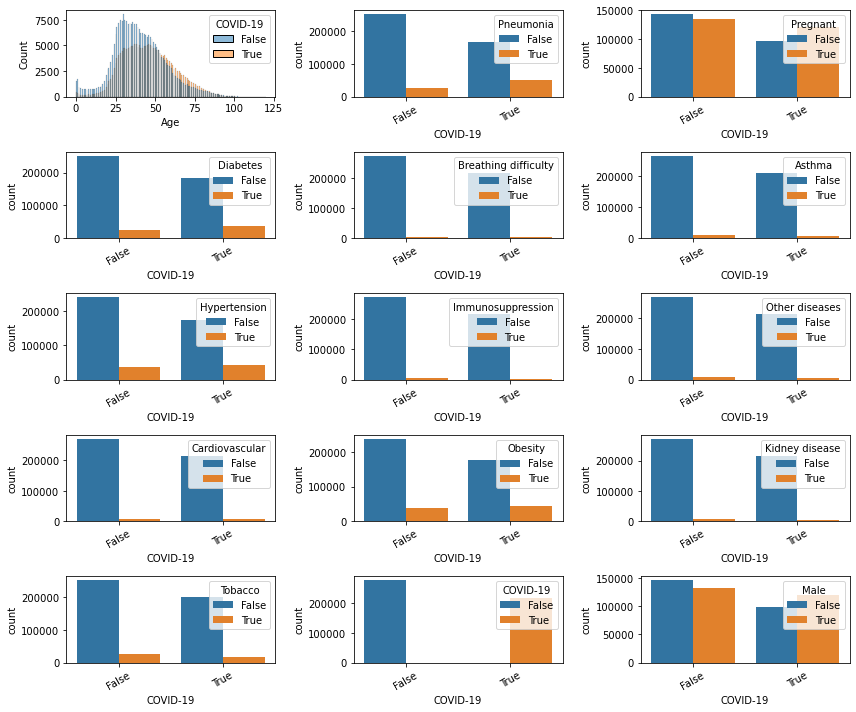

In [6]:
cols = mexico_df.columns
fig, axes = plt.subplots(5,3, figsize=(12,10))
axes = axes.flatten()

for i, col in enumerate(cols):
  if col != 'Age':
    plot(-2, i, mexico_df, axes[i])
sns.histplot(x='Age', hue='COVID-19', ax=axes[0], data=mexico_df)

plt.tight_layout()
plt.show()

## Brazil data processing

In [7]:
!kaggle datasets download -d cprete/covid19-open-datasets-for-brazil --unzip
brazil_sars_df = pd.read_csv('SARS_01-06/SRAG_01-06.csv', sep=';')



  0%|          | 0.00/139M [00:00<?, ?B/s]
  1%|          | 1.00M/139M [00:00<01:15, 1.92MB/s]
  2%|▏         | 3.00M/139M [00:00<00:54, 2.62MB/s]
  5%|▌         | 7.00M/139M [00:00<00:37, 3.64MB/s]
  8%|▊         | 11.0M/139M [00:00<00:26, 5.00MB/s]
 10%|█         | 14.0M/139M [00:01<00:21, 5.96MB/s]
 12%|█▏        | 16.0M/139M [00:01<00:20, 6.42MB/s]
 13%|█▎        | 18.0M/139M [00:01<00:16, 7.46MB/s]
 14%|█▍        | 20.0M/139M [00:01<00:13, 9.14MB/s]
 20%|██        | 28.0M/139M [00:01<00:09, 12.3MB/s]
 24%|██▍       | 33.0M/139M [00:01<00:06, 15.9MB/s]
 27%|██▋       | 38.0M/139M [00:02<00:05, 19.9MB/s]
 31%|███       | 43.0M/139M [00:02<00:04, 24.1MB/s]
 35%|███▍      | 48.0M/139M [00:02<00:03, 28.0MB/s]
 38%|███▊      | 53.0M/139M [00:02<00:02, 30.3MB/s]
 43%|████▎     | 59.0M/139M [00:02<00:02, 34.6MB/s]
 46%|████▌     | 64.0M/139M [00:02<00:02, 37.1MB/s]
 50%|████▉     | 69.0M/139M [00:02<00:01, 38.8MB/s]
 54%|█████▍    | 75.0M/139M [00:03<00:02, 30.1MB/s]
 65%|██████▍   | 90

In [8]:
idx = [12, 14, 15, 17, 18, 32, 33, 34, 35, 36, 37, 38, 39, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 126]
cols = ['Sex','Age', 'Age Type', 'Pregnant', 'Race', 'Fever', 'Cough', 'Throat infection', 'Breathing difficulty', 'Respiratory', 'Low oxygen levels', 
        'Diarrhea', 'Vomiting', 'Additional Symptoms', 'Cardiovascular', 'Hematologic (Blood Disease)', 'Down Syndrome', 'Liver disease', 'Asthma',
        'Diabetes', 'Neurological', 'Pneumonia', 'Immunosuppression', 'Kidney disease', 'Obesity', 'COVID-19']

In [9]:
brazil_sars_df = brazil_sars_df.iloc[:, idx]
brazil_sars_df.columns = cols

In [10]:
brazil_sars_df['COVID-19'] = brazil_sars_df['COVID-19'] == 5.0
brazil_sars_df['Age'].where(brazil_sars_df['Age Type'] == 3, inplace=True, other=1)
del brazil_sars_df['Age Type']
brazil_sars_df['Myalgia'] = brazil_sars_df['Additional Symptoms'] == "MIALGIA"
brazil_sars_df['Headache'] = brazil_sars_df['Additional Symptoms'] == "CEFALEIA"
del brazil_sars_df['Additional Symptoms']
brazil_sars_df['Sex'].where(brazil_sars_df['Sex'] == 'I', inplace=True, other='M')
brazil_sars_df['Male'] = brazil_sars_df['Sex'] == 'M'
del brazil_sars_df['Sex']
brazil_sars_df['Pregnant'].where(brazil_sars_df['Pregnant'] < 5, inplace=True, other=False)
brazil_sars_df['Pregnant'] = brazil_sars_df['Pregnant'] != 0
brazil_sars_df.iloc[:, 3:-4] = brazil_sars_df.iloc[:, 3:-4] == 1.
brazil_sars_df['Race'].where(brazil_sars_df['Race'] != 9, inplace=True, other=2)
brazil_sars_df['Race'].where(brazil_sars_df['Race'] != 5, inplace=True, other=4)
brazil_sars_df['Race'].replace([1.,2.,3.,4.], ["White", "Black", "Asian", "Hispanic/Latino"], inplace=True)

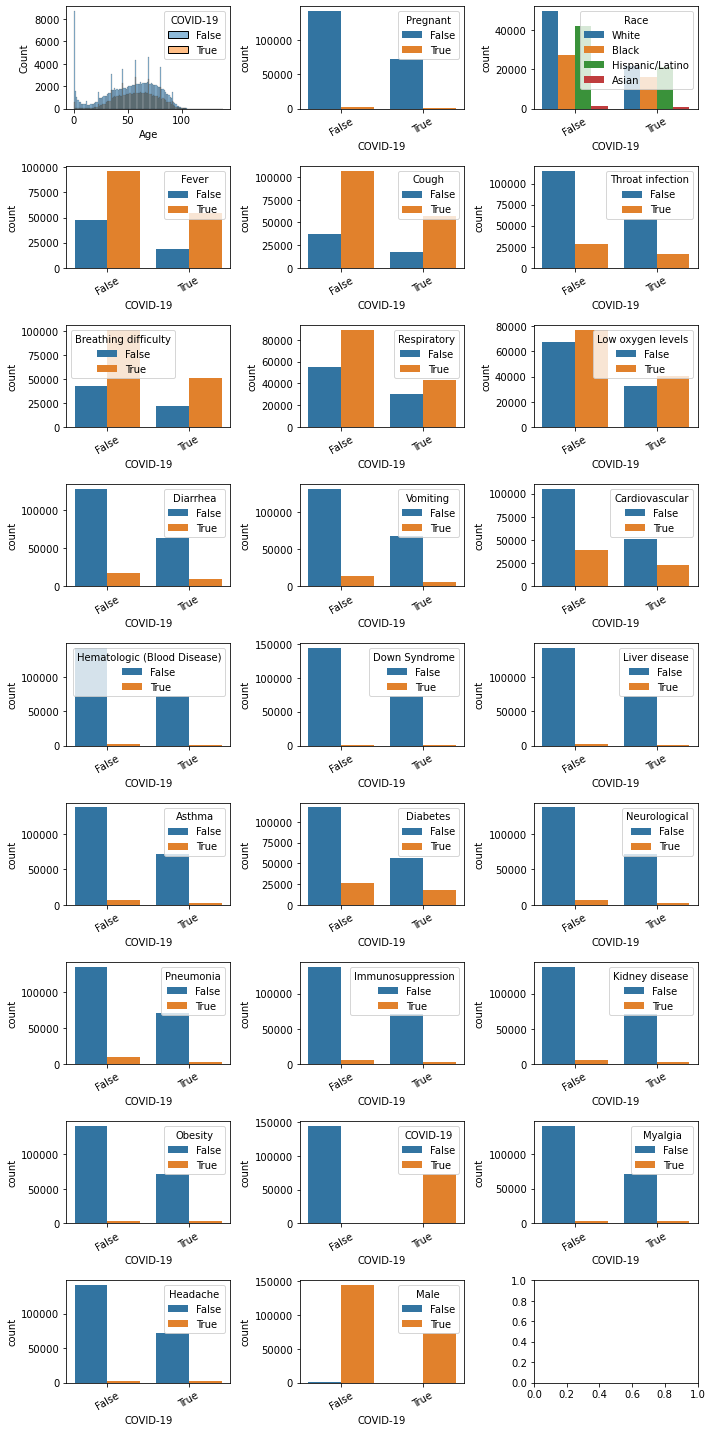

In [11]:
cols = brazil_sars_df.columns
fig, axes = plt.subplots(9,3, figsize=(10,20))
axes = axes.flatten()

for i, col in enumerate(cols):
  if col != "Age":
    plot(-4, i, brazil_sars_df, axes[i])
sns.histplot(hue='COVID-19', x='Age', data=brazil_sars_df, ax=axes[0])

plt.tight_layout()
plt.show()

In [12]:
# One Hot Encode Race

brazil_sars_df = pd.get_dummies(brazil_sars_df, drop_first=True)

## Israel data processing

In [13]:
keras.utils.get_file('israel.zip', 'https://github.com/nshomron/covidpred/blob/master/data/corona_tested_individuals_ver_0083.english.csv.zip?raw=true',
                     extract=True, cache_dir='./', cache_subdir='')
israel_df = pd.read_csv('corona_tested_individuals_ver_0083.english.csv')

C:\Users\Checkout\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [14]:
israel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2742596 entries, 0 to 2742595
Data columns (total 10 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   test_date            object
 1   cough                int64 
 2   fever                int64 
 3   sore_throat          int64 
 4   shortness_of_breath  int64 
 5   head_ache            int64 
 6   corona_result        object
 7   age_60_and_above     object
 8   gender               object
 9   test_indication      object
dtypes: int64(5), object(5)
memory usage: 209.2+ MB


In [15]:
israel_df.drop(labels=['test_date', 'test_indication'], inplace=True, axis=1)
israel_df['age_60_and_above'] = israel_df['age_60_and_above'] == "Yes"
israel_df['corona_result'] = israel_df['corona_result'] == "positive"
israel_df['Male'] = israel_df['gender'] == "male"
del israel_df['gender']
israel_df.rename(columns={'sore_throat': 'Sore Throat',
                          'head_ache': 'Headache',
                          'age_60_and_above': 'Age above 60',
                          'shortness_of_breath': 'Breathing difficulty'}, 
                 inplace=True)
israel_df.columns = [s.capitalize() for s in israel_df.columns]
israel_df.rename(columns={'Corona_result': 'COVID-19'}, inplace=True)

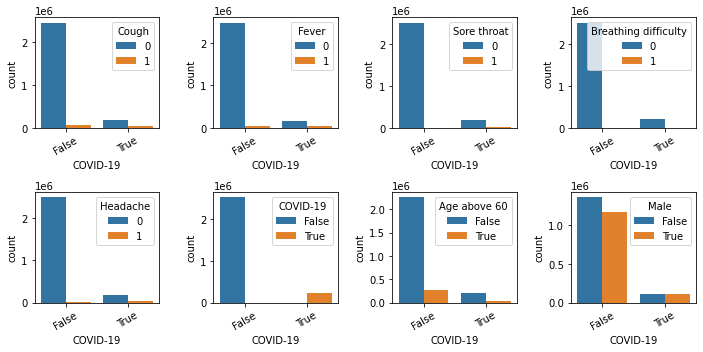

In [16]:
cols = israel_df.columns
fig, axes = plt.subplots(2,4, figsize=(10,5))
axes = axes.flatten()

for i, col in enumerate(cols):
  plot(5, i, israel_df, axes[i])

plt.tight_layout()
plt.show()

# Model Training and Comparison

In [17]:
def train_and_evaluate(clf, df, train=True):
  X, y = df.drop(['COVID-19'], axis=1), df['COVID-19']
  if train:
    clf.fit(X, y)
  y_pred = clf.predict(X)
  print('Precision Score: {}%'.format(round(precision_score(y_pred, y) * 100, 2)))
  print('Recall Score: {}%'.format(round(recall_score(y_pred, y) * 100, 2)))

In [55]:
mexico_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 496291 entries, 0 to 499691
Data columns (total 15 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   Age                   496291 non-null  int64
 1   Pneumonia             496291 non-null  bool 
 2   Pregnant              496291 non-null  bool 
 3   Diabetes              496291 non-null  bool 
 4   Breathing difficulty  496291 non-null  bool 
 5   Asthma                496291 non-null  bool 
 6   Hypertension          496291 non-null  bool 
 7   Immunosuppression     496291 non-null  bool 
 8   Other diseases        496291 non-null  bool 
 9   Cardiovascular        496291 non-null  bool 
 10  Obesity               496291 non-null  bool 
 11  Kidney disease        496291 non-null  bool 
 12  Tobacco               496291 non-null  bool 
 13  COVID-19              496291 non-null  bool 
 14  Male                  496291 non-null  bool 
dtypes: bool(14), int64(1)
memory usage

In [56]:
brazil_sars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217925 entries, 0 to 217924
Data columns (total 28 columns):
 #   Column                       Non-Null Count   Dtype
---  ------                       --------------   -----
 0   Age                          217925 non-null  int64
 1   Pregnant                     217925 non-null  bool 
 2   Fever                        217925 non-null  bool 
 3   Cough                        217925 non-null  bool 
 4   Throat infection             217925 non-null  bool 
 5   Breathing difficulty         217925 non-null  bool 
 6   Respiratory                  217925 non-null  bool 
 7   Low oxygen levels            217925 non-null  bool 
 8   Diarrhea                     217925 non-null  bool 
 9   Vomiting                     217925 non-null  bool 
 10  Cardiovascular               217925 non-null  bool 
 11  Hematologic (Blood Disease)  217925 non-null  bool 
 12  Down Syndrome                217925 non-null  bool 
 13  Liver disease                

In [57]:
israel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2742596 entries, 0 to 2742595
Data columns (total 8 columns):
 #   Column                Dtype
---  ------                -----
 0   Cough                 int64
 1   Fever                 int64
 2   Sore throat           int64
 3   Breathing difficulty  int64
 4   Headache              int64
 5   COVID-19              bool 
 6   Age above 60          bool 
 7   Male                  bool 
dtypes: bool(3), int64(5)
memory usage: 112.5 MB


## Mexico Dataset Models

### Support Vector Machine (SVM) - Training Too Slow

In [47]:
mexico_svm = SVC(random_state=42, kernel='linear', verbose=1)
# train_and_evaluate(mexico_svm, mexico_df, recall_score)

### K-Means Clustering

In [ ]:
mexico_kmeans = KMeans(n_clusters=2, verbose=0, n_init=3, init='k-means++')
train_and_evaluate(mexico_kmeans, mexico_df)

### Random Forest

In [18]:
mexico_rf = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=100)
train_and_evaluate(mexico_rf, mexico_df)

Precision Score: 37.45%
Recall Score: 67.84%


In [22]:
joblib.dump(mexico_rf, 'mexico_model.joblib', compress=1)
joblib.dump(mexico_df.columns, 'mexico_cols.joblib')

['mexico_cols.joblib']

### Gradient Boosted Decision Tree (XGBoost)

In [ ]:
mexico_xgb = XGBClassifier(random_forest=42, n_estimators=100, learning_rate=0.3, n_jobs=-1)
train_and_evaluate(mexico_xgb, mexico_df)

### Multi Layer Perceptron (MLP)

In [ ]:
X, y = mexico_df.drop(['COVID-19'], axis=1).astype(np.float32), mexico_df['COVID-19']
# X = np.expand_dims(X.values, 0)

model = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(20, activation='relu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(8, activation='relu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(1, activation='sigmoid')
])
epochs=50
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

model.compile(loss="binary_crossentropy", optimizer="Nadam", metrics=["Precision", "Recall"])
history = model.fit(X, y, epochs=epochs, batch_size=32)

## Brazil Dataset Models

### Support Vector Machine (SVM) - Training too Slow

In [ ]:
brazil_svm = SVC(random_state=42, kernel='linear', verbose=2)
train_and_evaluate(brazil_svm, brazil_sars_df, recall_score)

### K-Means Clustering

In [ ]:
brazil_kmeans = KMeans(n_clusters=2, verbose=0, n_init=10)
train_and_evaluate(brazil_kmeans, brazil_sars_df)

### Random Forest

In [23]:
brazil_rf = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=100)
train_and_evaluate(brazil_rf, brazil_sars_df)

Precision Score: 62.38%
Recall Score: 79.94%


In [29]:
joblib.dump(brazil_rf, 'brazil_model.joblib', compress=7)
joblib.dump(brazil_sars_df.columns, 'brazil_cols.joblib')

['brazil_cols.joblib']

### Gradient Boosted Decision Tree (XGBoost)

In [34]:
brazil_xgb = XGBClassifier(random_forest=42, n_estimators=100, learning_rate=0.3, n_jobs=-1)
train_and_evaluate(brazil_xgb, brazil_sars_df)

Precision Score: 6.09%
Recall Score: 53.92%


## Israel Dataset Models

### Support Vector Machine (SVM) - Training too Slow

In [ ]:
mexico_svm = SVC(random_state=42, kernel='linear', verbose=2)
# train_and_evaluate(mexico_svm, mexico_df, recall_score)

### K-Means Clustering

In [ ]:
israel_kmeans = KMeans(n_clusters=2, verbose=0, n_init=3)
train_and_evaluate(israel_kmeans, israel_df)

### Random Forest

In [30]:
israel_rf = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=100)
train_and_evaluate(israel_rf, israel_df)

Precision Score: 31.31%
Recall Score: 65.57%


In [31]:
joblib.dump(israel_rf, 'israel_model.joblib')
joblib.dump(israel_df.columns, 'israel_cols.joblib')

['israel_cols.joblib']

### Gradient Boosted Decision Tree (XGBoost)

In [27]:
israel_xgb = XGBClassifier(random_forest=42, n_estimators=100, learning_rate=0.3, n_jobs=-1)
train_and_evaluate(israel_xgb, israel_df)

Precision Score: 31.12%
Recall Score: 65.57%


# Testing Data Preprocessing

## India Synthetic Data

In [ ]:
!kaggle datasets download -d prakharsrivastava01/covid19-symptoms-dataset --unzip

In [ ]:
india_test_df = pd.read_excel('covid19-symptoms-dataset.xlsx')

In [ ]:
india_test_df.info()

In [ ]:
india_test_df.iloc[:, :-1] = india_test_df.iloc[:, :-1] != 0
india_test_df.iloc[:, -1] = india_test_df.iloc[:, -1] == "Yes" 

In [ ]:
cols = india_test_df.columns
fig, axes = plt.subplots(2,3, figsize=(10,6))
axes = axes.flatten()

for i, col in enumerate(cols):
  plot(-1, i, india_test_df, axes[i])

plt.tight_layout()
plt.show()

## India WHO Synthetic Data

In [ ]:
!kaggle datasets download -d hemanthhari/symptoms-and-covid-presence --unzip

In [ ]:
india_who_test_df = pd.read_csv('Covid Dataset.csv')

In [ ]:
india_who_test_df.info()

In [ ]:
india_who_test_df = india_who_test_df.iloc[:, np.r_[:13, 20]]
india_who_test_df = india_who_test_df == "Yes"

In [ ]:
cols = india_who_test_df.columns
fig, axes = plt.subplots(4,4, figsize=(15,10))
axes = axes.flatten()

for i, col in enumerate(cols):
  plot(-1, i, india_who_test_df, axes[i])

plt.tight_layout()
plt.show()

## US Mayo Clinic Synthetic Data

In [ ]:
!kaggle datasets download -d walterconway/covid-flu-cold-symptoms --unzip

In [ ]:
us_mayo_test_df = pd.read_csv('large_data.csv')

In [ ]:
us_mayo_test_df.info()

In [ ]:
us_mayo_test_df['COVID-19'] = us_mayo_test_df['TYPE'] == "COVID"
del us_mayo_test_df['TYPE']

In [ ]:
us_mayo_test_df.info()

## US CDC Data - All positive

In [ ]:
!kaggle datasets download -d arashnic/covid19-case-surveillance-public-use-dataset
us_df = pd.read_csv('covid19-case-surveillance-public-use-dataset.zip') 

In [ ]:
us_df.info()

In [ ]:
us_df = us_df[['sex', 'age_group', 'Race and ethnicity (combined)', 'medcond_yn']].dropna()
us_df = us_df[~us_df.isin(["Missing", "Unknown", "Other"])]
us_df['Race and ethnicity (combined)'] = us_df['Race and ethnicity (combined)'].str.split(',').str[0]
us_df['Race and ethnicity (combined)'] = us_df['Race and ethnicity (combined)'].str.split('/').str[0]
us_df['age_group'] = us_df['age_group'].str.split(' Y').str[0]

In [ ]:
cols = us_df.columns
fig, axes = plt.subplots(4,4, figsize=(20,15))
for i, col in enumerate(cols):
  for j, col2 in enumerate(cols):
    plot(i, j, us_df.sample(10000, random_state=42), axes[i][j])

plt.tight_layout()
plt.show()